# Lab 3: Interpolation and Quadrature
Kabilan Sriranjan

13/04/18

In [20]:
import math
import numpy as np
import scipy.special as scp
import matplotlib.pyplot as plt

## Question 1.

We can compute $||L_n||$ for Chebyshev interpolation by just evaluating the sum of the Lagrange polynomials $|\phi_{n,k}(x)|$ at the maximum value. This is easy for Chebyshev interpolation as the maximum is achieved at $x=1$.

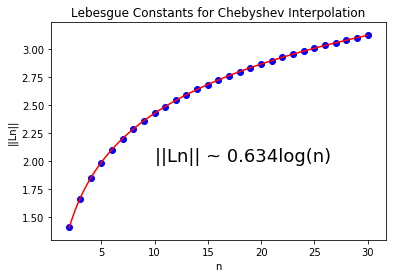

In [21]:
#Create n Chebyshev nodes in the interval (-1,1)
def chebyNodes(n):
    k = np.array(range(1,n+1))
    return np.cos((2*k-1)*np.pi/(2*n))[::-1]

#Evaluate the kth Lagrange basis polynomial for a given set of nodes at the point x
def phi(k, x, nodes):
    x_k = nodes[k]
    product = 1
    for x_i in nodes:
        if x_i != x_k:
            product = product * (x-x_i)/(x_k-x_i)
    return product

#Compute the Lebesgue constant for degree n Chebyshev interpolation
def Lcheby(n):
    nodes = chebyNodes(n)
    leb = 0;
    for i in range(n):
        leb = leb + np.abs(phi(i, 1, nodes))
    return leb

minimum = 2
maximum = 30
n = np.array(range(minimum, maximum+1))
Ls = []
for i in n:
    Ls.append(Lcheby(i))

fit = np.polyfit(np.log(n), Ls, deg=1)
x = np.linspace(minimum, maximum, 100)
y = fit[1] + fit[0]*np.log(x)
plt.plot(x, y, color="red")
plt.scatter(n, Ls, color="blue")
plt.text(10,2,"||Ln|| ~ "+str(round(fit[0], 3))+"log(n)", fontsize=18)
plt.title("Lebesgue Constants for Chebyshev Interpolation")
plt.xlabel("n")
plt.ylabel("||Ln||")
plt.show()

As we can see $||L_n||$ grows logaithmically with n. Our estimate for the constant $C$ is $0.634$.

## Question 2

To compute $||L_n||$ for regular Lagrange interpolation with equidistant nodes we must approximate the maximum value of $\lambda_n(x)$ This can be done by computing the derivative, $\lambda^{\prime}_n(x)$ and using the secant method to find its roots. We use as the initial guess, $x_0$, the point $9/10^{th}s$ towards left bounday ,-1, and $1/10^{th}$ towards the leftmost node as it seemed to have better performance.

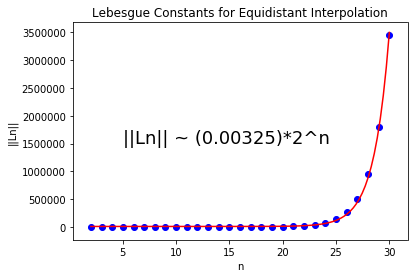

-0.791925558135


In [22]:
#Create equally spaced nodes in the interval (-1,1)
def equinodes(n):
    return np.linspace(-1,1,n)

#Compute the derivative of a Lagrange basis function at x
def dphi(k, x, nodes):
    den = 1
    xs = []
    for i in range(len(nodes)):
        if i!=k:
            xs.append(nodes[i])
            den = den*(nodes[k]-nodes[i])
    num = 0
    for s in xs:
        product = 1
        for t in xs:
            product = product * (x-t)
        product = product/(x-s)
        num = num + product
    return num/den

#Give +/-1, the sign of x
def sign(x):
    return x/np.abs(x)

#Newton-Raphson method for root finding
def newtRaph(k, nodes, x_0, eps):
    while np.abs(phi(k, x_0, nodes)) > eps:
        x_0 = x_0 - phi(k, x_0, nodes)/dphi(k, x_0, nodes)
    return x_0

#Secant method for root finding
def secantApprox(nodes, x_0, eps):
    while np.abs(dlam(x_0, nodes)) > eps:
        x_0 = x_0 - dlam(x_0, nodes)/((dlam(x_0+eps**2, nodes)-dlam(x_0-eps**2, nodes))/(2*eps**2))
    return x_0
        
#Compute the sum of the Lagrange polynomials at x
def lam(x, nodes):
    l = 0
    for i in range(len(nodes)):
        l = l+np.abs(phi(i, x, nodes))
    return l

#Compute the derivative of the sum of the Lagrange functions
def dlam(x, nodes):
    dl = 0
    for i in range(len(nodes)):
        dl = dl+sign(phi(i,x,nodes))*dphi(i, x, nodes)
    return dl

#Approximate the Lebesgue constant for Lagrange interpolation with equally spaced nodes
def Lequi(n):
    nodes = equinodes(n)
    maximizer = secantApprox(nodes, 9*nodes[0]/10 + nodes[1]/10, 0.0001)
    return lam(maximizer, nodes)

n = np.array(range(2, maximum+1))
Ls = []
for i in n:
    Ls.append(Lequi(i))
    
fit = np.polyfit(2**n, Ls, deg=1)  
x = np.linspace(minimum, maximum, 100)
y = fit[1] + fit[0]*(2**x)
plt.plot(x, y, color="red")
plt.scatter(n, Ls, color="blue")
plt.text(5,1500000,"||Ln|| ~ ("+str(round(fit[0], 5))+")*2^n", fontsize=18)
plt.title("Lebesgue Constants for Equidistant Interpolation")
plt.xlabel("n")
plt.ylabel("||Ln||")
plt.show()

print(secantApprox(equinodes(5), -0.75, 0.0001))

And so we have experimentally confirmed the dependance $||L_n|| \approx 2^n$.

## Question 3

We aim to approximate $||S_n||$ for Chebyshev truncation. To do so we must approximate the integral $\int_0^\pi \mid \frac{sin((n+\frac{1}{2})\theta)}{2sin(\frac{\theta}{2})} \mid dx$, which can be tricky to do well. Hence we specifcally choose our nodes to be of the form $\theta_i = \frac{k\pi}{3(n+\frac{1}{2})}$ so that we have 3 nodes for every root.

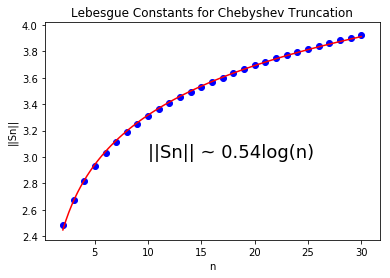

In [23]:
#Evaluate nth Chebyshev truncation function at theta
def sCheby(n, theta):
    return np.abs(np.sin((n+1/2)*theta)/(2*np.sin(theta/2)))

#Created nodes alligned with the nth Chebyshev truncation function
def sNodes(n):
    nodes = [0.000001]
    k = 1
    theta = k*np.pi/((n+0.5)*3)
    while theta < np.pi:
        nodes.append(theta)
        k = k+1
        theta = k*np.pi/((n+0.5)*3)
    nodes.append(np.pi)
    return nodes

#Approximate integral from 0 to pi of of Chebyshev truncation function
def SCheby(n):
    nodes = sNodes(n)
    area = 0
    for i in range(0, len(nodes)-1):
        left = sCheby(n, nodes[i])
        right = sCheby(n, nodes[i+1])
        area = area+((left+right)/2)*(nodes[i+1]-nodes[i])
    return area

n = np.array(range(minimum, maximum+1))
Ss = []
for i in n:
    Ss.append(SCheby(i))

fit = np.polyfit(np.log(n), Ss, deg=1)
x = np.linspace(minimum, maximum, 100)
y = fit[1] + fit[0]*np.log(x)
plt.plot(x, y, color="red")
plt.scatter(n, Ss, color="blue")
plt.text(10,3,"||Sn|| ~ "+str(round(fit[0], 3))+"log(n)", fontsize=18)
plt.title("Lebesgue Constants for Chebyshev Truncation")
plt.xlabel("n")
plt.ylabel("||Sn||")
plt.show()

From the plot of $||S_n||$ against $n$ we can estimate the constant $C$ as $0.54$ in the dependance $||S_n|| = Clog(n)$ 

## Question 4

To compute $||S_n||$ for Legendre truncation we need to integrate the Legendre polynomials. This can be done exactly but for simplicity we use the trapezoid rule to approximate them instead.

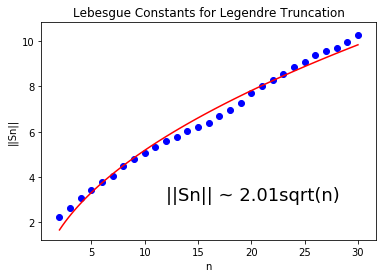

In [26]:
#Evaluate nth Legendre polynomial at x
def legPoly(n, x):
    total = 0
    for k in range(0, n+1):
        total = total+(scp.binom(n,k)**2)*((x-1)**(n-k))*((x+1)**k)
    return total/(2**n)

#Compute a_k in the Legendre truncation
def a(k):
    return (2*k+1)/2

#Compute the Legndre truncation function at x
def sLeg(n, x):
    total = 0
    for k in range(0, n+1):
        total = total + a(k)*legPoly(k,x)
    return np.abs(total)

#Approximate the integral of the nth Legendre truncation function
def SLeg(n):
    nodes = np.linspace(-1,1,n*5)
    area = 0
    for i in range(0, len(nodes)-1):
        left = sLeg(n, nodes[i])
        right = sLeg(n, nodes[i+1])
        area = area+((left+right)/2)*(nodes[i+1]-nodes[i])
    return area
    
n = np.array(range(minimum, maximum+1))
Ss = []
for i in n:
    Ss.append(SLeg(i))

fit = np.polyfit(np.sqrt(n), Ss, deg=1)
x = np.linspace(minimum, maximum, 100)
y = fit[1] + fit[0]*np.sqrt(x)
plt.plot(x, y, color="red")
plt.scatter(n, Ss, color="blue")
plt.text(12,3,"||Sn|| ~ "+str(round(fit[0], 3))+"sqrt(n)", fontsize=18)
plt.title("Lebesgue Constants for Legendre Truncation")
plt.xlabel("n")
plt.ylabel("||Sn||")
plt.show()

For Legendre truncation we see the dependance $S_n = C\sqrt{n}$ where $C$ is estimated to be $2.01$. 

## Question 5

To compute $||Q_n||$ for Newtwon-Cotes style quadrature we need to integrate the Lagrange basiss function for equally spaced nodes. Again we choose to approximate these integrals for the sake of simplicity, even though it can be done exactly.

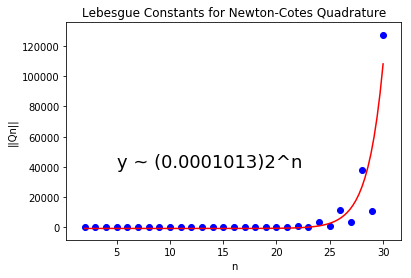

In [28]:
#Approximate the integral of the kth Lagrange basis function for given nodes
def Qphi(k, nodes):
    a = 0
    b = 1
    intNodes = np.linspace(a,b,len(nodes)*2)
    area = 0
    for i in range(0, len(intNodes)-1):
        left = phi(k,intNodes[i],nodes)
        right = phi(k,intNodes[i+1],nodes)
        area = area+((left+right)/2)*(intNodes[i+1]-intNodes[i])
    return area

#Compute the sum of the integrals of Lagrange basis functions
def Q(n):
    nodes = np.linspace(0,1,n+1)
    total = 0
    for k in range(0, n+1):
        total = total+np.abs(Qphi(k, nodes))
    return total

n = np.array(range(minimum, maximum+1))
Qs = []
for i in n:
    Qs.append(Q(i))
    
fit = np.polyfit(2**n, Qs, deg=1)
x = np.linspace(minimum, maximum, 100)
y = fit[1] + fit[0]*(2**x)
plt.plot(x, y, color="red")
plt.scatter(n,Qs, color="blue")
plt.text(5,40000,"y ~ ("+str(round(fit[0], 7))+")2^n", fontsize=18)
plt.title("Lebesgue Constants for Newton-Cotes Quadrature")
plt.xlabel("n")
plt.ylabel("||Qn||")
plt.show()

From the plot it appears that $||Q_n||$ grows exponentially with $n$. The graph isn't perfect but this is probably due to rounding error and instability of some computations for large n.